# Programming Exercise 4: Neural Networks Learning

## Introduction
In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. Before starting on the programming exercise, we strongly recommend watching the video lectures and complelting the review questions for the associated topics.

## 1. Neural Networks
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to *learn* the parameters for the neural network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize
from scipy.io import loadmat  # to load .mat file

%matplotlib inline

### 1.1. Visualizing the data
In the first part of the exercise, the code will load the data and display it on a 2-dimensional plot by calling the function `displayData`. This is the same dataset that you used in the previous exercise. There are 5000 training examples in `ex4data1.mat`, where each training example is 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \left[\begin{array}{ccc} \text{——} (x^{(1)})^T \text{——} \\ \text{——} (x^{(2)})^T \text{——} \\ \vdots \\ \text{——} (x^{(m)})^T \text{——} \end{array}\right] $$

The second part of the training set is 5000-dimensional vector $y$ that contains labels for the training set. Because this exercise was at first created for Octave/MATLAB, to make things more compatible, the digit zero has been mapped to the value ten. Therefore, a "0" digit is labeled as "10", where the digits "1" to "9" are labeled as "1" to "9" in their natural order.

In [2]:
# Loading and Visualizing Data
data = loadmat('data/ex4/ex4data1.mat')  # data is a 'dict' object
# Get X and y from dict data
X = data['X']  # (5000, 400) ndarray
y = data['y']  # (5000, 1) ndarray

m = X.shape[0] # the number of training examples
input_layer_size = 400 # 20x20 input images of digits
hidden_layer_size = 25 # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10

# Randomly select 100 data points to display
rand_indices = np.random.randint(0, m, 100)

In [3]:
def display_data(X, example_width=None):
    """
    `display_data(X, example_width)` displays 2D data stored in X in a nice
    grid.
    """
    
    if (example_width == None):
        example_width = int(np.sqrt(X.shape[1]))
        
    # Compute the number of images, the pixels of each image
    m, pixels = X.shape
    
    # Compute the height of each image
    w = example_width
    h = int(pixels / w)
    
    # Compute nubmer of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    # print(display_rows, display_cols)
    
    # The padding between images
    h_padding = -np.ones((1, (w+1)*display_cols+1))
    v_padding = -np.ones((h, 1))
    
    # Setup blank display
    display_array = h_padding
    row_images = v_padding
    
    # Rearange the data
    # Note that the scan order used by reshape in NumPy defaults to
    # the ‘C’ order, whereas MATLAB uses the Fortran order. We can do
    # transpose to make the transform.
    # https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
    stacked_images = X.reshape(m * h, w)
    split_stacked_images = np.array(np.vsplit(stacked_images, range(h, m*h, h)))
    # print(split_stacked_images.shape)
    
    for i in range(1, display_rows*display_cols+1):
        
        # if can't be displaed as a exact square
        if i > m:
            single_image = -np.ones((h, w)) # blank
        else:
            single_image = split_stacked_images[i-1].T # digit image
        
        if (i % display_cols) == 0:
            # print("i = " + str(i), "display_cols = " + str(display_cols))
            row_images = np.hstack((row_images, single_image))
            row_images = np.hstack((row_images, v_padding))
            display_array = np.vstack((display_array, row_images))
            display_array = np.vstack((display_array, h_padding))
            row_images = v_padding # clear row_images to v_padding
        else:
            row_images = np.hstack((row_images, single_image))
            row_images = np.hstack((row_images, v_padding))
    
    # print(display_array.shape)
    
    # Display image
    plt.imshow(display_array, cmap='gray')
    plt.axis("off")

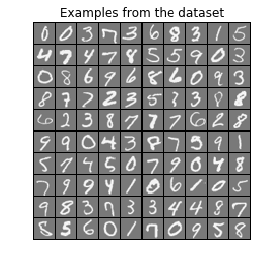

[[10 10  3  7  3  6  8  3  1  5]
 [ 4  7  4  7  8  5  5  9 10  3]
 [10  8  6  9  6  8  6 10  9  3]
 [ 8  7  7  2  3  5  3  3  8  8]
 [ 6  2  3  8  7  7  7  6  2  8]
 [ 9  9 10  4  3  8  7  5  9  1]
 [ 5  7  4  5 10  7  9 10  4  8]
 [ 7  9  9  4  1 10  6  1 10  5]
 [ 9  8  3  7  3  3  4  4  8  7]
 [ 5  5  6 10  1  7 10  9  5  8]]


In [4]:
# Plot examples fromt the dataset
display_data(X[rand_indices])
plt.title("Examples from the dataset")
plt.show()
print(y[rand_indices].reshape(10, 10))

### 1.2. Model representation
Our neural work is shown in the following figure.
![Neural Network model](data/ex3/neural-network-model.jpg)
It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the iamges are of 20 $\times$ 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data will be loaded into the variables $X$ and $y$ by the script.

You have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in `ex4weights.mat` and will be loaded into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [5]:
# Load the weights into variables Theta1 and Theta2
nn_params = loadmat('data/ex4/ex4weights.mat')
Theta1 = nn_params["Theta1"]  # Theta1.shape = (25, 401)
Theta2 = nn_params["Theta2"]  # Theta2.shape = (10, 26)

### 1.3. Feedforward and cost function
Now you have implement the cost function and gradient for the neural network. First, complete the code in `compute_cost` function to return the cost.

Recall that the cost function for the neural network (without regularization) is
$$J(\theta) = \frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K \left[-y_k^{(i)} \log((h_{\theta}(x^{(i)}))_k) - (1-y_k^{(i)})\log(1-(h_{\theta}(x^{(i)}))_k)\right]$$
where $h_{\theta}(x^{(i)})$ is computed as shown in the above figure, and $K = 10$ is the total number of possible labels. Note that $h_{\theta}(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k$-th output unit. Also, recall that whereas the original labels (in the variable $y$) were 1, 2, $\ldots$, 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that
$$y = \left[\begin{array}{c} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{array}\right], \quad \left[\begin{array}{c} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{array}\right], \quad, \cdots \quad or \left[\begin{array}{c} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{array}\right] $$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_{\theta}(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \geq 3$ labels).

### 1.4. Regularized cost function
The cost function for neural networks with regularization is given by
$$J(\theta) = \frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K \left[-y_k^{(i)} \log((h_{\theta}(x^{(i)}))_k) - (1-y_k^{(i)})\log(1-(h_{\theta}(x^{(i)}))_k)\right] + \frac{\lambda}{2m}\left[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\right]$$

In [6]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [7]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (m, n_x)
    nn_params -- python dictionary containing your parameters (output of initialization function)
        Theta1 -- nn_params["Theta1"]
        Theta2 -- nn_params["Theta2"]
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    # Get Theta1 and Theta2 from parameters
    Theta1 = parameters["Theta1"]  # Theta1.shape = (25, 401)
    Theta2 = parameters["Theta2"]  # Theta2.shape = (10, 26)
        
    A0 = X.T
    A0 = np.vstack((np.ones((1, A0.shape[1])), A0))  # A0.shape = (401, 5000)
    Z1 = np.dot(Theta1, A0)  # Z1.shape = (25, 5000)
    A1 = sigmoid(Z1)  
    A1 = np.vstack((np.ones((1, A1.shape[1])), A1))  # A1.shape = (26, 5000)
    Z2 = np.dot(Theta2, A1)  # Z2.shape = (10, 5000)
    A2 = sigmoid(Z2)  # A2.shape = (10, 5000)
    
    cache = {"A0": A0,
             "Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [8]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    # Turn y into Y
    one_hot = np.zeros((C, labels.shape[0]))
    for i in range(one_hot.shape[1]):
        one_hot[:, i][labels[i]-1] = 1
        
    return one_hot

In [9]:
# Turn labels y into one hot matrix Y
Y = one_hot_matrix(y, num_labels)

In [10]:
def compute_cost(A2, Y, parameters, lambd=0):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation
    Y -- The labels of the images, one hot matrix
    parameters -- dictionary containing parameters Theta1 and Theta2
    
    Returns:
    cost -- cross-entropy cost
    """
    
     # Get Theta1 and Theta2 from parameters
    Theta1 = parameters["Theta1"]  # Theta1.shape = (25, 401)
    Theta2 = parameters["Theta2"]  # Theta2.shape = (10, 26)
    m = Y.shape[1] # the number of the examples
    
    assert(A2.shape == Y.shape)

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = - np.sum(logprobs) / m + (np.sum(Theta1[:, 1:] ** 2)
            + np.sum(Theta2[:, 1:] ** 2)) * lambd / (2 * m)
    
    cost = np.squeeze(cost)  # makes sure cost is the dimension we expect. 
                             # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [11]:
print("Feedforward Using Neural Network ...")

# Weight regularization parameter (set 0 here)
lambd = 0
A2, cache = forward_propagation(X, nn_params)
J = compute_cost(A2, Y, nn_params, lambd)
print("Cost at parameters (loaded from ex4weights): " + str(J)
      + " (this value should be about 0.287629)")

print("\nChecking Cost Function (w/ Regularization) ...")

# Weight regularization parameter (set 1 here)
lambd = 1
A2, cache = forward_propagation(X, nn_params)
J = compute_cost(A2, Y, nn_params, lambd)
print("Cost at parameters (loaded from ex4weights): " + str(J)
      + " (this value should be about 0.383770)")

Feedforward Using Neural Network ...
Cost at parameters (loaded from ex4weights): 0.287629165161 (this value should be about 0.287629)

Checking Cost Function (w/ Regularization) ...
Cost at parameters (loaded from ex4weights): 0.383769859091 (this value should be about 0.383770)


## 2. Backpropagation
In this part of the exercise, you will implement the backpropagation algo- rithm to compute the gradient for the neural network cost function.

### 2.1. Sigmoid gradient
To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as
$$ g'(z) = \frac{\text{d}}{\text{d}z}g(z) = g(z)(1-g(z)) $$
where
$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [12]:
def sigmoid_gradient(z):
    """
    Compute the gradient of the sigmoid function
    """
    g = np.multiply(sigmoid(z), 1-sigmoid(z))
    
    return g

In [13]:
print("Evaluating sigmoid gradient ...")
g = sigmoid_gradient(np.array([-1, 0.5, 0, 0.5, 1]))
print("Sigmoid gradient evaluated at [-1, 0.5, 0, 0.5, 1]: ")
print(g)
print("Expected value: [0.196612 0.235004 0.250000 0.235004 0.196612]")

Evaluating sigmoid gradient ...
Sigmoid gradient evaluated at [-1, 0.5, 0, 0.5, 1]: 
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]
Expected value: [0.196612 0.235004 0.250000 0.235004 0.196612]


### 2.2. Random Initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{[l]}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$ This range of values ensures that the parameters are kept small and makes the learning more effcient.

In [14]:
def rand_initialize_weights(L_in, L_out):
    """
    Randomly initialize the weights of a layer with L_in incoming
    connections and L_out outgoing connections
    """
    
    # Randomly initialize the weights to small values
    epsilon_init = 0.12;
    W = np.random.rand(L_out, 1+L_in) * 2 * epsilon_init - epsilon_init
    
    return W

In [15]:
# Initialize parameters
def initialize_parameters(input_layer_size, hidden_layer_size, num_labels):
    initial_Theta1 = rand_initialize_weights(input_layer_size, \
                                             hidden_layer_size)
    initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels)
    initial_nn_params = {"Theta1": initial_Theta1,
                         "Theta2": initial_Theta2}
    
    return initial_nn_params;

### 2.3. Backpropagation
Now, you will implement the backpropagation algorithm. Recall that
the intuition behind the backpropagation algorithm is as follows. Given a
training example $(x^{(t)},y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_{\Theta}(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the difference between the
network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

1. Set the input layer’s values $(a^{(1)})$ to the $t$-th training example $x^{(t)}$. Perform a feedforward pass, computing cache the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3.
2. For each output unit $k$ in layer 3 (the output layer), set
$$ \delta_k^{(3)} = (a_k^{(3)} - y_k), $$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ ($y_k = 1$), or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).
3. For hidden layer $l = 2$, set
$$ \delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)} * g'(z^{(2)}) \quad 
\text{(element-wise muliplication)} $$
4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T $$
5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$\frac{\partial}{\partial \Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} $$

### 2.4. Regularization in Backpropagation
To account for regularization, you will add regularization to the radient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, yo should add regularization using
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} \qquad \text{for } j = 0 $$
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} \qquad \text{for } j \geq 1 $$

Note that you should *not* be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus
$$ \Theta^{(l)} = \left[\begin{array}{ccc} \Theta_{1,0}^{(i)} & \Theta_{1,1}^{(i)} & \ldots \\ \Theta_{2,0}^{(i)} & \Theta_{2,1}^{(i)} & \\ \vdots & & \ddots \end{array}\right] $$

In [16]:
def backward_propagation(parameters, cache, X, Y, lambd):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (number of examples, input_layer_size)
    Y -- "true" labels vector of shape (num_labels, number of examples)
    
    Returns:
    grads -- dictionary containing gradients with respect to different parameters
    """
    
    m = X.shape[0] # the number of examples
    
    # Get Theta1 and Theta2 from parameters
    Theta1 = parameters["Theta1"]  # Theta1.shape = (25, 401)
    Theta2 = parameters["Theta2"]  # Theta2.shape = (10, 26)
    
    A0 = cache["A0"]  # A0.shape = (401, 5000)
    Z1 = cache["Z1"]  # Z1.shape = (25, 5000)
    A1 = cache["A1"]  # A1.shape = (26, 5000)
    Z2 = cache["Z2"]  # Z2.shape = (10, 5000)
    A2 = cache["A2"]  # A2.shape = (10, 5000)
    
    dZ2 = A2 - Y  # dZ2.shape = (10, 5000)
    dTheta2 = np.dot(dZ2, A1.T) / m  # dTheta2.shape = (10, 5000) @ (5000, 26) = (10, 26)
    dZ1 = np.dot(Theta2[:, 1:].T, dZ2) * sigmoid_gradient(Z1)  # dZ1.shape = Z1.shape = A1.shape = (25, 5000)
    dTheta1 = np.dot(dZ1, A0.T) / m  # dTheta1.shape = (25, 5000) @ (5000, 401) = (25, 401)
    
    # Regularization
    dTheta1[:, 1:] = dTheta1[:, 1:] + lambd / m * Theta1[:, 1:]
    dTheta2[:, 1:] = dTheta2[:, 1:] + lambd / m * Theta2[:, 1:]
    
    assert(dTheta1.shape == Theta1.shape)
    assert(dTheta2.shape == Theta2.shape)
    
    grads = {"dTheta1": dTheta1,
             "dTheta2": dTheta2}
    
    return grads

### 2.5. Gradient checking
In your neural network, you are minimizing the cost function $J(\Theta)$, To perform gradient checking on your parameters, you can imagine "unrolling" parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i}J(\theta)$; you'd like to check if $f_i$ is outputting correct derivative values.
$$ \text{Let} \quad \theta^{(i+)} = \theta + \left[\begin{array}{c} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{array}\right] \qquad \text{and} \quad \theta^{(i-)} = \theta - \left[\begin{array}{c} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{array}\right] $$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i$-th element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the $i$-th element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$'s correctness by checking, for each $i$, that:
$$ f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you'll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more). The `check_nn_gradients` function will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct, you should see a relative difference that is less than 1e-9.

For each $i$ in num_parameters:
- To compute `J_plus[i]`:
    1. Set $\theta^{+}$ to `np.copy(parameters_values)`
    2. Set $\theta^{+}_i$ to $\theta^{+}_i + \varepsilon$
    3. Calculate $J^{+}_i$ using to `forward_propagation_n(x, y, vector_to_dictionary(`$\theta^{+}$ `))`.     
- To compute `J_minus[i]`: do the same thing with $\theta^{-}$
- Compute $gradapprox[i] = \frac{J^{+}_i - J^{-}_i}{2 \varepsilon}$

Thus, you get a vector gradapprox, where gradapprox[i] is an approximation of the gradient with respect to `parameter_values[i]`. You can now compare this gradapprox vector to the gradients vector from backpropagation. Just like for the 1D case (Steps 1', 2', 3'), compute: 
$$ difference = \frac {\| grad - gradapprox \|_2}{\| grad \|_2 + \| gradapprox \|_2 } \tag{3}$$

In [17]:
def vector_to_dictionary(nn_params, i, h, n):
    """
    Convert column vector `nn_params` to dictionary `parameters`
    """
    
    parameters = {}
    parameters["Theta1"] = nn_params[:h*(i+1), :].reshape((h, i+1), order='F')
    parameters["Theta2"] = nn_params[h*(i+1):, :].reshape((n, h+1), order='F')
    
    return parameters

In [18]:
def debug_initialize_weights(fan_out, fan_in):
    """
    Initializes the weights of a layer with fan_in incoming connections
    and fan_out outgoing connections using a fix set of values
    """
    
    # Set W a sequnce and reshape it in Fotran order
    W = np.arange(1, fan_out*(1+fan_in)+1)
    W = W.reshape((fan_out, 1 + fan_in), order='F')
    
    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.sin(W) / 10
    
    return W

In [19]:
def check_nn_gradients(lambd=0, epsilon=1e-7):
    """
    Creates a small neural network to check the backpropagation gradients,
    it will output the analytical gradients produced by your backprop code
    and the numerical gradients (computed using computeNumericalGradient).
    These two gradient computations should result in very similar values.
    """
    
    input_s = 3
    hidden_s = 5
    out_s = 3
    m = 5
    
    # Generate the test weights
    Theta1 = debug_initialize_weights(hidden_s, input_s)
    Theta2 = debug_initialize_weights(out_s, hidden_s)
    
    # Generate X and labels y
    X = debug_initialize_weights(m, input_s-1)
    y = (1 + np.mod(np.arange(1, m+1), out_s)).T
    
    # Turn labels y into one_hot matrix
    Y = one_hot_matrix(y, out_s)
    
    # Unroll parameters
    nn_params = np.vstack((Theta1.reshape((-1, 1), order='F'),
                           Theta2.reshape((-1, 1), order='F')))
    parameters = vector_to_dictionary(nn_params, input_s, hidden_s, out_s)
    
    # Get the grad by backward_propagation
    _, cache = forward_propagation(X, parameters)
    gradients = backward_propagation(parameters, cache, X, Y, lambd)  # dict
    grad = np.vstack((gradients["dTheta1"].reshape((-1, 1), order='F'),
                      gradients["dTheta2"].reshape((-1, 1), order='F')))
    
    # Set-up variables
    num_parameters = nn_params.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute numerical gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]. Inputs: "nn_params, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        thetaplus = np.copy(nn_params)                                        # Step 1
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                   # Step 2
        A2, _ = forward_propagation(X, vector_to_dictionary(thetaplus, input_s, hidden_s, out_s))   # Step 3
        J_plus[i] = compute_cost(A2, Y, vector_to_dictionary(thetaplus, input_s, hidden_s, out_s), lambd)
        
        # Compute J_minus[i]. Inputs: "nn_params, epsilon". Output = "J_minus[i]".
        thetaminus = np.copy(nn_params)                                       # Step 1
        thetaminus[i][0] = thetaminus[i][0] - epsilon                                 # Step 2        
        A2, _ = forward_propagation(X, vector_to_dictionary(thetaminus, input_s, hidden_s, out_s)) # Step 3
        J_minus[i] = compute_cost(A2, Y, vector_to_dictionary(thetaminus, input_s, hidden_s, out_s), lambd)
        
        # Compute gradapprox[i]
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
    
    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad - gradapprox)                                     # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                   # Step 2'
    difference = numerator / denominator                                              # Step 3'
    
    for i in range(grad.shape[0]):
        print(grad[i], gradapprox[i])
    
    if difference > 1e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = "
               + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = "
               + str(difference) + "\033[0m")

In [20]:
check_nn_gradients(lambd=3, epsilon=1e-7)

[-0.00927825] [-0.00927825]
[ 0.00889912] [ 0.00889912]
[-0.00836011] [-0.00836011]
[ 0.00762814] [ 0.00762814]
[-0.00674798] [-0.00674798]
[-0.01676798] [-0.01676798]
[ 0.03943348] [ 0.03943348]
[ 0.05933556] [ 0.05933556]
[ 0.0247641] [ 0.0247641]
[-0.03268814] [-0.03268815]
[-0.06017447] [-0.06017447]
[-0.03196123] [-0.03196123]
[ 0.02492255] [ 0.02492256]
[ 0.05977176] [ 0.05977176]
[ 0.03864105] [ 0.03864105]
[-0.01737047] [-0.01737047]
[-0.05756587] [-0.05756587]
[-0.04519638] [-0.04519638]
[ 0.00914588] [ 0.00914588]
[ 0.05461015] [ 0.05461015]
[ 0.31454497] [ 0.31454497]
[ 0.11105659] [ 0.11105659]
[ 0.0974007] [ 0.0974007]
[ 0.11868267] [ 0.11868267]
[  3.81928696e-05] [  3.81938925e-05]
[ 0.03369266] [ 0.03369265]
[ 0.20398713] [ 0.20398713]
[ 0.11714823] [ 0.11714824]
[ 0.07548013] [ 0.07548013]
[ 0.12569807] [ 0.12569807]
[-0.00407588] [-0.00407588]
[ 0.01696771] [ 0.01696771]
[ 0.17633755] [ 0.17633755]
[ 0.11313314] [ 0.11313314]
[ 0.0861629] [ 0.0861629]
[ 0.13229414] [ 

In [21]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    # Retrieve each parameter from the dictionary "parameters"
    Theta1 = parameters["Theta1"]  # Theta1.shape = (25, 401)
    Theta2 = parameters["Theta2"]  # Theta2.shape = (10, 26)
    
    # Retrieve each gradient from the dictionary "grads"
    dTheta1 = grads["dTheta1"]
    dTheta2 = grads["dTheta2"]
    
    # Update rule for each parameter
    Theta1 = Theta1 - learning_rate * dTheta1
    Theta2 = Theta2 - learning_rate * dTheta2
    
    parameters = {"Theta1": Theta1,
                  "Theta2": Theta2}
    
    return parameters

In [22]:
def nn_model(X, Y, input_layer_size, hidden_layer_size, num_labels, \
             lambd=0, num_iterations=10000, learning_rate=0.1,
             print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    # Initialize parameters, then retrieve Theta1, Theta2
    parameters = initialize_parameters(input_layer_size, hidden_layer_size, num_labels)
    Theta1 = parameters["Theta1"]
    Theta2 = parameters["Theta2"]
    
    for i in range(num_iterations+1):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters, lambd)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y, lambd)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return parameters

In [23]:
parameters = nn_model(X, Y, input_layer_size, hidden_layer_size, num_labels,
                      lambd=0, num_iterations=5000, learning_rate=0.3,
                      print_cost = True)

Cost after iteration 0: 7.136839
Cost after iteration 1000: 0.609716
Cost after iteration 2000: 0.433692
Cost after iteration 3000: 0.354602
Cost after iteration 4000: 0.302249
Cost after iteration 5000: 0.262506


In [24]:
def predict(X, parameters):
    """
    Predict the label of an input given a trained neural network.
    """
    
    Theta1 = parameters["Theta1"]
    Theta2 = parameters["Theta2"]
    
    m = X.shape[0]  # the number of examples
    num_labels = Theta2.shape[0] # the number of labels
    
    # Get the output of the network by forward propagation
    A2, _ = forward_propagation(X, parameters)
    
    # Get the max value's index for each row (rank 1 array)
    p = np.argmax(A2, axis=0) + 1
    # return a column vector
    return p[np.newaxis].T

In [25]:
# Predict the labels
pred = predict(X, parameters)
accuracy = np.sum(pred == y) / m * 100
print("Training set accuracy: " + str(accuracy))

Training set accuracy: 96.84


## 3. Visualizing the hidden layer
One way to understand what your neural network is learning is to visualize
what the representations captured by the hidden units. Informally, given a
particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value $(a^{(l)})$ close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.
Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 $\times$ 20 image and display it. The next step is using the `display_data` function and it will show you an image with 25 units, each corresponding to one hidden unit in the network.

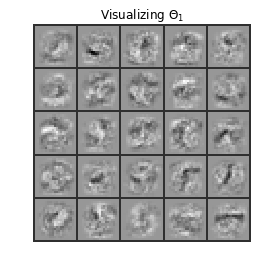

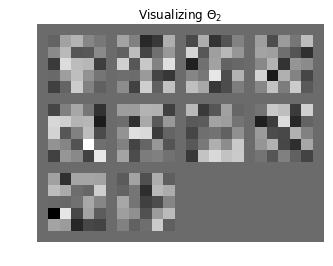

In [26]:
display_data(Theta1[:, 1:])
plt.title(r"Visualizing $\Theta_1$")
plt.show()

display_data(Theta2[:, 1:])
plt.title(r"Visualizing $\Theta_2$")
plt.show()